In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [15]:
from utils.model_utils import fix_seeds
from utils.datasets import CPDDatasets
from utils.cpd_models import CPDModel
from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel, DistanceEnsembleCPDModel
from utils.metrics import (
    evaluation_pipeline,
    write_metrics_to_file, 
    evaluate_cusum_ensemble_model, 
    evaluate_distance_ensemble_model, 
    compute_stds,
    collect_model_predictions_on_set
)
from utils.visualize import visualize_predictions

import itertools
import math
import yaml

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
class OutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_uncertainties_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (batch_size, seq_len)
        self.test_out = list(torch.vstack(test_out_bank))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
        self.test_uncertainties = list(torch.vstack(test_uncertainties_bank))  

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return (self.test_out[idx], self.test_uncertainties[idx]), self.test_labels[idx]
    
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (n_models, batch_size, seq_len)
        self.test_out = list(torch.hstack(test_out_bank).transpose(0, 1))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

In [5]:
class ABAnnealingLR(_LRScheduler):
  """Step size scheduler for SGLD.

  a and b are computed based on start and final step size.

  .. math::
    \epsilon_t = a(b + t)^{-\gamma}

  .. _SGLD\: Bayesian Learning via Stochastic Gradient Langevin Dynamics:
        https://icml.cc/2011/papers/398_icmlpaper.pdf
  """
  def __init__(self, optimizer, final_lr, gamma, T_max, last_epoch=-1, verbose=False):
    self.final_lr = final_lr
    self.gamma = gamma
    self.T_max = T_max

    super().__init__(optimizer, last_epoch, verbose)

  def get_lr(self):
    if not self._get_lr_called_within_step:
      warnings.warn("To get the last learning rate computed by the scheduler, "
                    "please use `get_last_lr()`.", UserWarning)

    if self.last_epoch == 0:
      return self.base_lrs

    new_lrs = []
    for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups):
      if self.last_epoch > self.T_max:
        new_lrs.append(group['lr'])
      else:
        b = self.T_max / ((base_lr / self.final_lr) * math.exp(1 / self.gamma) - 1.)
        a = base_lr * b ** self.gamma

        new_lr = a / (b + self.last_epoch) ** self.gamma
        new_lrs.append(new_lr)
        
    return new_lrs


In [6]:
def mimic_abannealing_lr(start_lr, final_lr, gamma, T_max, last_epoch=-1):
    lrs = [start_lr]
    for _ in range(last_epoch):
        base_lr = lrs[-1]
        b = T_max / ((base_lr / final_lr) * math.exp(1 / gamma) - 1.)
        a = base_lr * b ** gamma

        new_lr = a / (b + last_epoch) ** gamma
        lrs.append(new_lr)
    return lrs

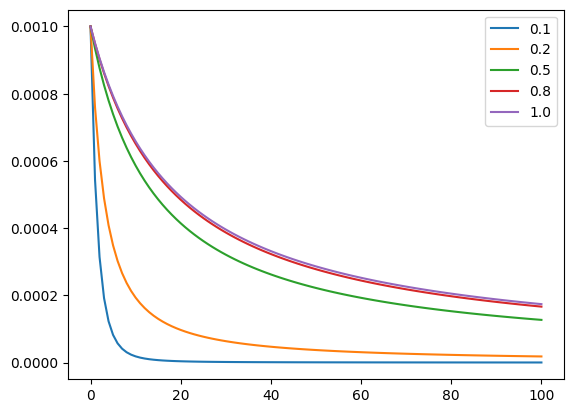

In [7]:
plt.figure()
for gamma in [0.1, 0.2, 0.5, 0.8, 1.0]:
    lrs_array = mimic_abannealing_lr(
        start_lr=1e-3,
        final_lr=1e-4,
        gamma=gamma,
        T_max=50000,
        last_epoch=100
    )
    plt.plot(lrs_array, label=gamma)
plt.legend()
plt.show()

In [7]:
class CustomNoisyAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=0, temperature=0.):
        super().__init__(params, lr=lr, betas=betas)
        self.weight_decay = weight_decay
        self.temperature = temperature

    def step(self, closure=None):
        if closure is not None:
            with torch.enable_grad():
                loss = closure() 
    
        for group in self.param_groups: 
            for p in group['params']: 
                if p.grad is None: 
                    continue
                grad = p.grad.data 
                if grad.is_sparse: 
                    raise RuntimeError("Adam does not support sparse gradients") 

                state = self.state[p] 

                # State initialization 
                if len(state) == 0: 
                    state["step"] = 0
                    # Exponential moving average of gradient values 
                    state["exp_avg"] = torch.zeros_like(p.data) 
                    # Exponential moving average of squared gradient values 
                    state["exp_avg_sq"] = torch.zeros_like(p.data) 

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
                beta1, beta2 = group["betas"] 

                state["step"] += 1

                if self.weight_decay != 0: 
                    grad = grad.add(p.data, alpha=self.weight_decay) 

                # Decay the first and second moment running average coefficient 
                exp_avg.mul_(beta1).add_(1 - beta1, grad) 
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad) 

                denom = exp_avg_sq.sqrt().add_(group["eps"]) 

                bias_correction1 = 1 - beta1 ** state["step"] 
                bias_correction2 = 1 - beta2 ** state["step"] 
                step_size = group["lr"] * math.sqrt(bias_correction2) / bias_correction1
                
                p.data.addcdiv_(-step_size, exp_avg, denom)
                
                # add noise
                noise = torch.rand_like(exp_avg)
                p.data.add_(noise, alpha=math.sqrt(2 * group["lr"] * self.temperature))

In [8]:
class CPDModelCustomNoisyAdam(CPDModel):
    def __init__(
        self,
        loss_type: str,
        args: dict,
        model: nn.Module,
        train_dataset: Dataset,
        test_dataset: Dataset,
    ) -> None:
        super().__init__(loss_type, args, model, train_dataset, test_dataset)
        
        self.temperature = args["learning"]["temperature"] 

        self.T_max = args["learning"]["T_max"]
        
        self.final_lr =  args["learning"]["final_lr"]
        self.gamma = args["learning"]["gamma"]

    def configure_optimizers(self):
        optimizer = CustomNoisyAdam(
            self.model.parameters(),
            lr=self.learning_rate,
            temperature=self.temperature
        )
        
        scheduler = ABAnnealingLR(
            optimizer,
            final_lr=self.final_lr,
            gamma=self.gamma,
            T_max=self.T_max,
            verbose=False 
        )
         
        return [optimizer], [scheduler]

# HAR

In [8]:
SEED = 42
fix_seeds(SEED)

model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1

args_config["learning"]["epochs"] = 100

In [9]:
train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
train_dataset[0][0].shape

(20, 28)

## Ensemble

In [10]:
path_to_models_folder = "saved_models/bce/human_activity/sgld_adam"

ens_har_sgld = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_har_sgld.load_models_list(path_to_models_folder)

In [11]:
test_dataset = ens_har_sgld.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))

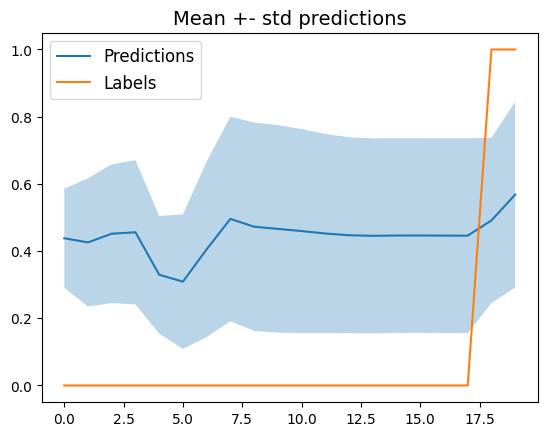

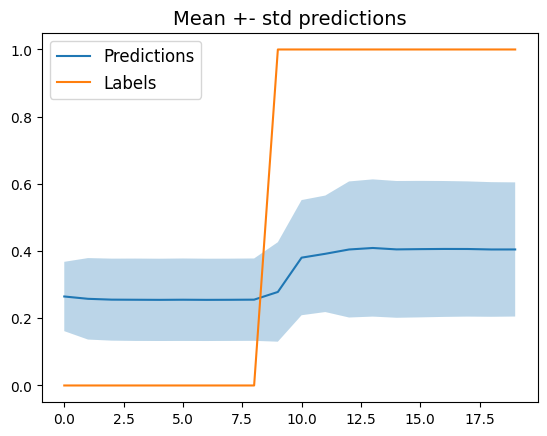

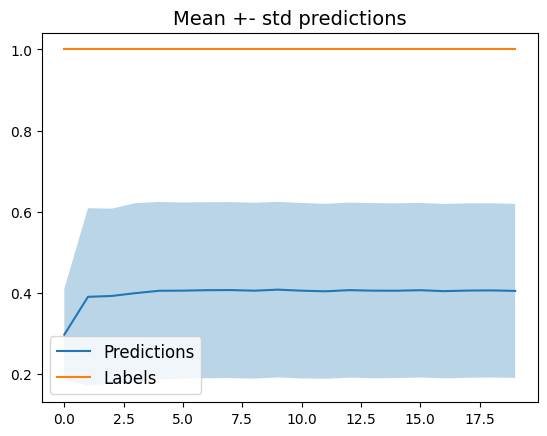

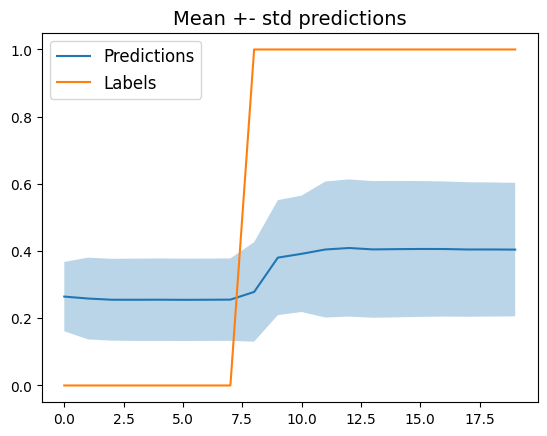

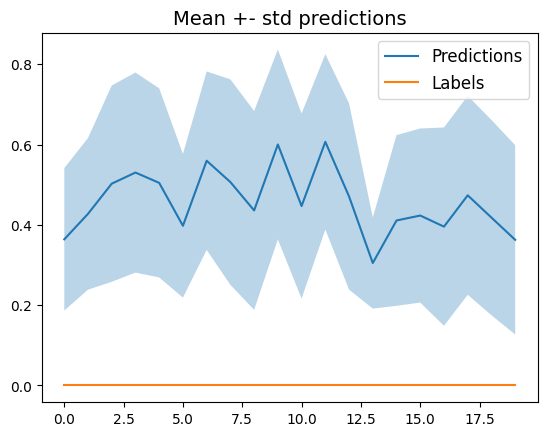

In [13]:
visualize_predictions(
   ens_har_sgld,
   "ensemble",
   seq_batch,
   labels_batch,
   n_pics=5
)

In [16]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = collect_model_predictions_on_set(
    ens_har_sgld,
    test_dataloader,
    model_type="ensemble",
    device="cpu"
)

out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

(preds, stds), labels = out_dataset[0]
preds.shape, stds.shape, labels.shape

Collectting model's outputs


(torch.Size([20]), torch.Size([20]), torch.Size([20]))

In [27]:
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
    ens_har_sgld,
    test_dataloader,
    threshold_list,
    device="cpu", 
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4]
)

Collectting model's outputs
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, FP_DELAY:0.9573672413825989, COVER: 0.6825056095736723
TN: 2, FP: 1251, FN: 62, TP: 22, DELAY:0.9274495244026184, F

In [32]:
compute_stds(
    ens_har_sgld,
    test_dataloader,
    windows_list=[1, 2, 3, 4],
    verbose=True,
    device="cpu"
);

  5%|▍         | 1/21 [00:00<00:02,  9.47it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 17.03it/s]


Window: 1
CP stds list:
Mean = 0.14856014578333035, number is 1141
Normal stds list:
Mean = 0.13804214436880832, number is 1304
p_val analytical = 8.908505798236434e-10, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.15283507589286718, number is 1141
Normal stds list:
Mean = 0.1382786181552647, number is 1268
p_val analytical = 1.4898405085521847e-17, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.15571617045154915, number is 1141
Normal stds list:
Mean = 0.13875750818722, number is 1224
p_val analytical = 2.0403367026156848e-22, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.1587303809162089, number is 1141
Normal stds list:
Mean = 0.13939830493769478, number is 1173
p_val analytical = 4.49008461714740

## CUSUMs and co

In [17]:
norm_sigma = 0.1382786
cp_sigma = 0.1528351

global_sigma = norm_sigma
lambda_null = 1. / cp_sigma ** 2
lambda_inf = 1. / norm_sigma ** 2
half_wnd = 1

In [24]:
ens_har_sgld_old = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="old",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_old.load_models_list(path_to_models_folder)

_ = ens_har_sgld_old.predict(seq_batch)
cusum_old = ens_har_sgld_old.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_correct_noncond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_correct_noncond.predict(seq_batch)
cusum_correct_noncond = ens_har_sgld_correct_noncond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_correct_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_correct_cond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_correct_cond.predict(seq_batch)
cusum_correct_cond = ens_har_sgld_correct_cond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_new_crit_noncond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_new_crit_noncond.predict(seq_batch)
new_crit_noncond = ens_har_sgld_new_crit_noncond.normal_to_change_stats.detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
ens_har_sgld_new_crit_cond.load_models_list(path_to_models_folder)

_ = ens_har_sgld_new_crit_cond.predict(seq_batch)
new_crit_cond = ens_har_sgld_new_crit_cond.normal_to_change_stats.detach().cpu()

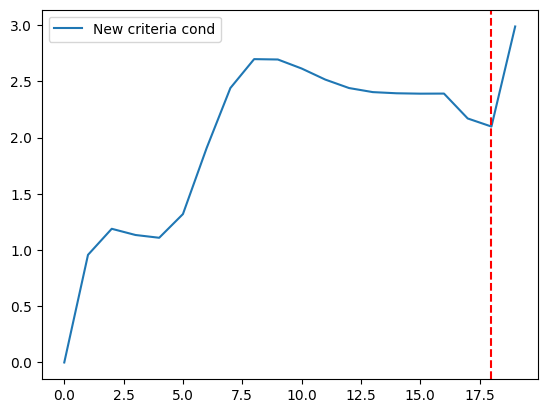

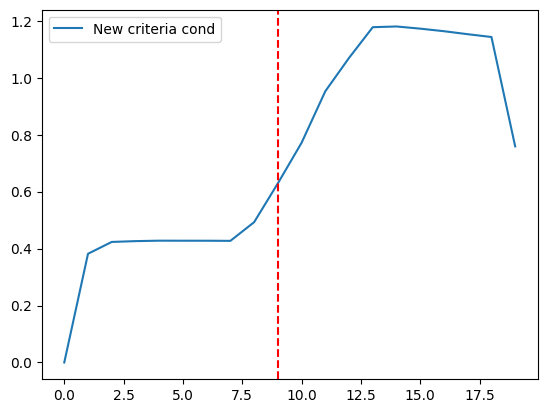

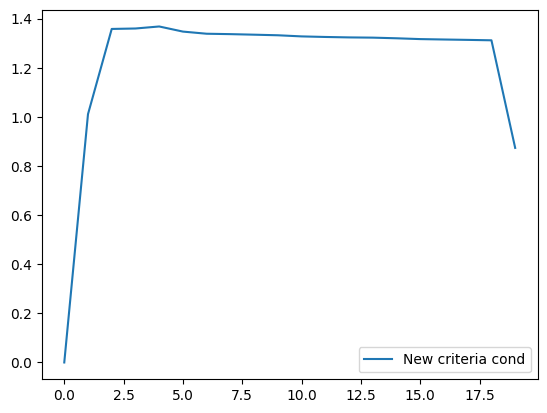

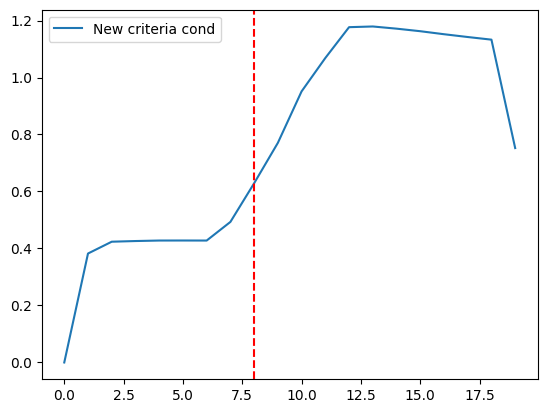

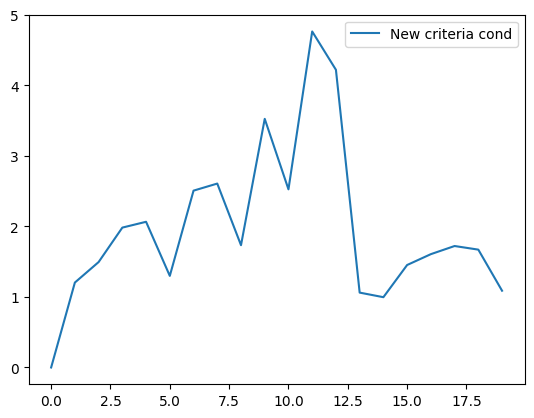

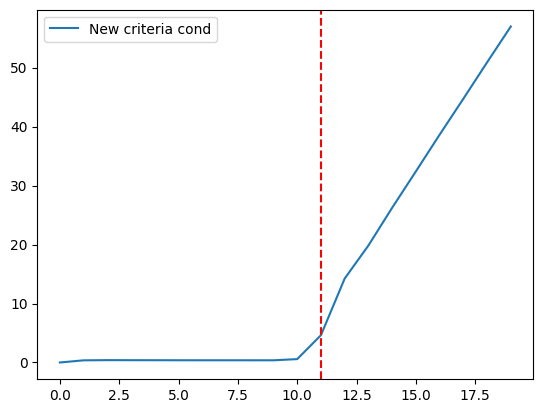

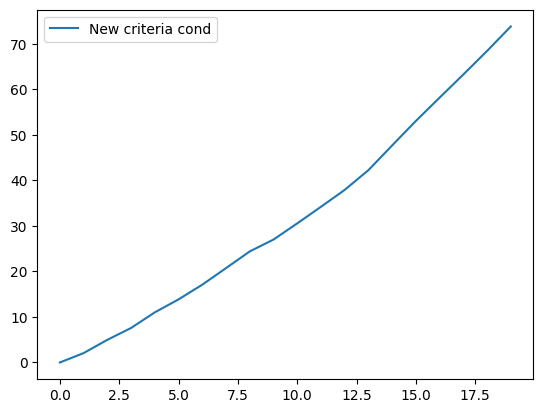

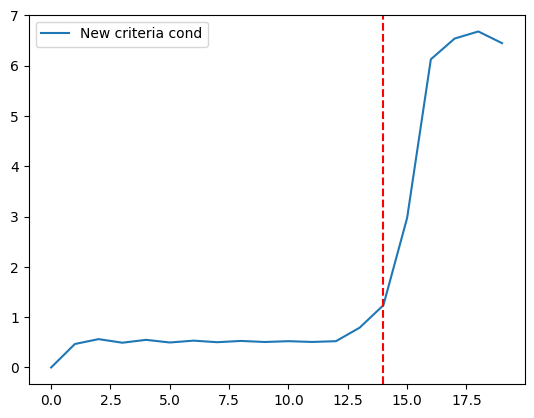

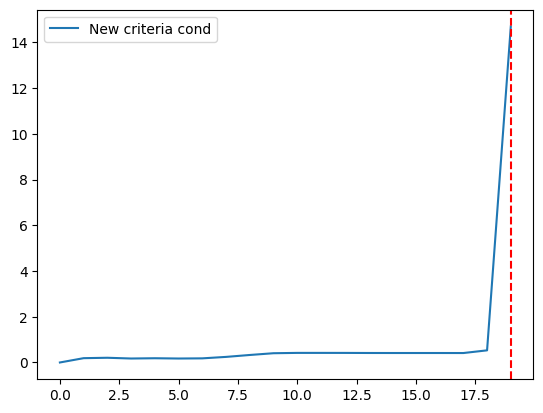

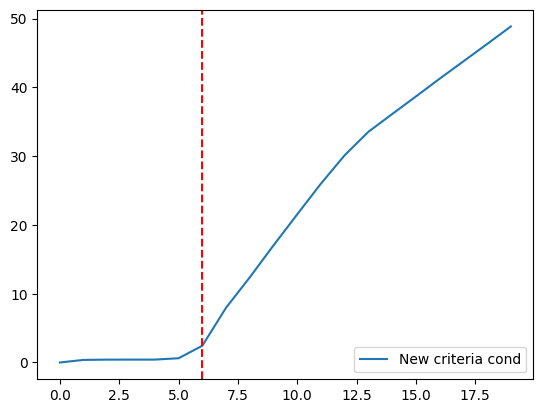

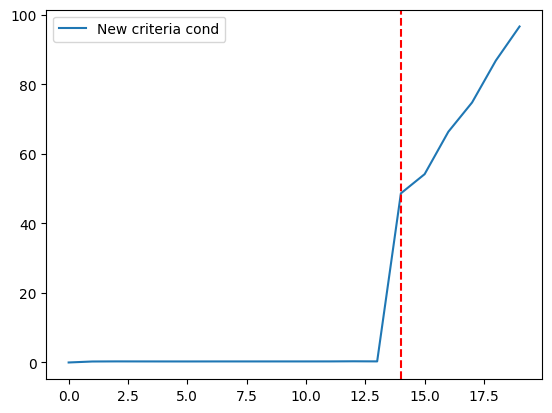

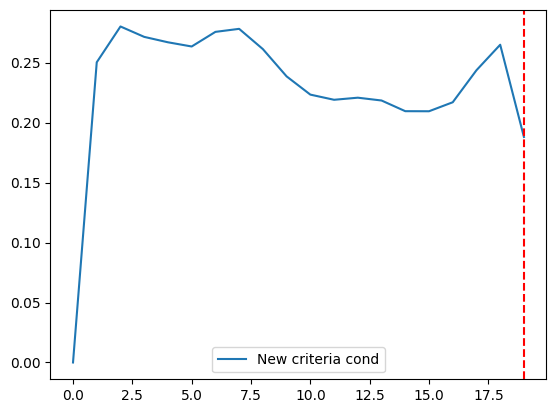

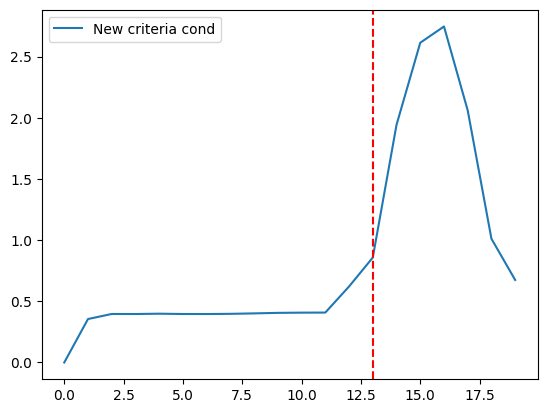

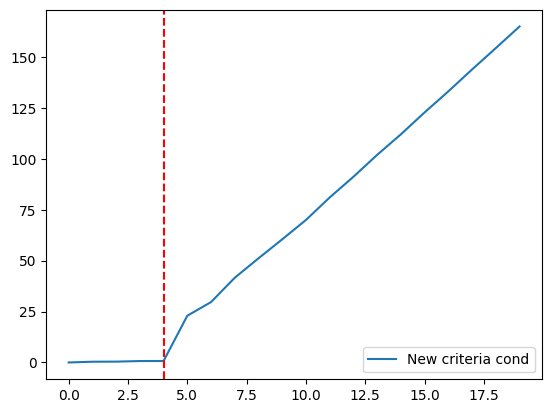

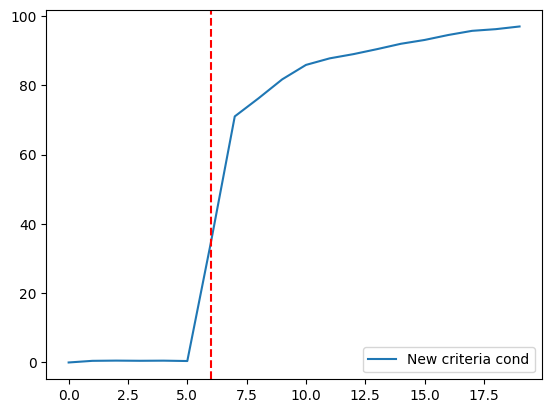

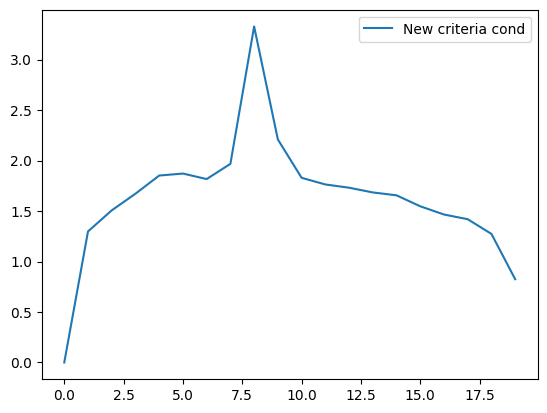

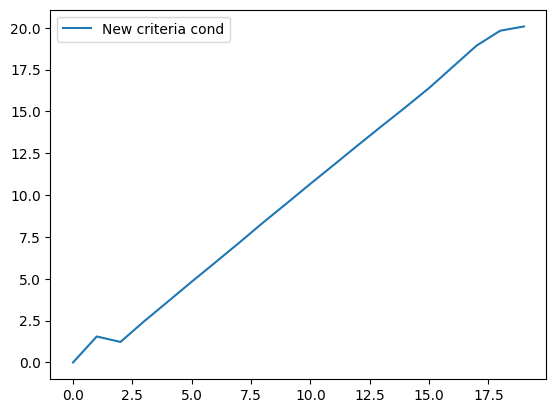

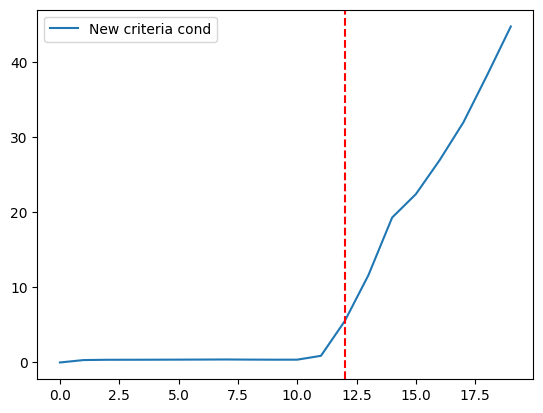

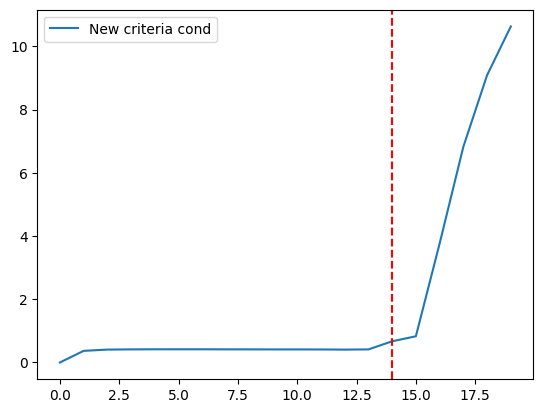

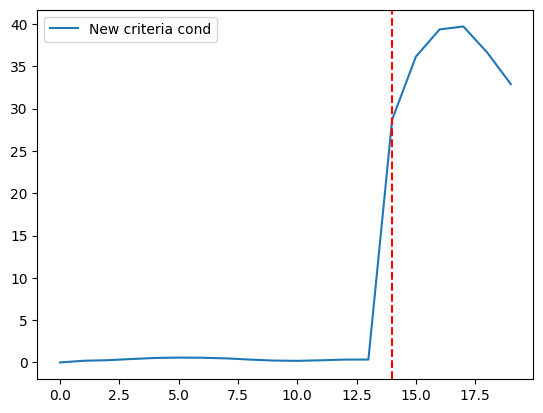

In [29]:
for IDX in range(20):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    #plt.plot(cusum_old[IDX], label="Old CUSUM")
    #plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    #plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    #plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [34]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="old",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]

Results for best threshold = 0.7070707070707071
AUDC: 0.0, Time to FA: 9.736, DD: 0.6313, F1: 0.9172, Cover: 0.9289, Max Cover: 0.9289
Max F1 with margin 1: 0.8872
Max F1 with margin 2: 0.8911
Max F1 with margin 4: 0.9102


In [41]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    #write_metrics_filename=path_to_metrics,
);

100%|██████████| 100/100 [03:21<00:00,  2.02s/it]

Results for best threshold = 3.0303030303030303
AUDC: 0.0, Time to FA: 10.6133, DD: 1.5946, F1: 0.8665, Cover: 0.88, Max Cover: 0.88
Max F1 with margin 1: 0.761
Max F1 with margin 2: 0.835
Max F1 with margin 4: 0.8665


In [42]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]

Results for best threshold = 1.4141414141414141
AUDC: 0.0, Time to FA: 10.7592, DD: 1.6313, F1: 0.8685, Cover: 0.8792, Max Cover: 0.8792
Max F1 with margin 1: 0.7508
Max F1 with margin 2: 0.838
Max F1 with margin 4: 0.8685


In [43]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
    #write_metrics_filename=path_to_metrics,
);

100%|██████████| 100/100 [03:20<00:00,  2.00s/it]

Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4488, DD: 0.6829, F1: 0.8897, Cover: 0.918, Max Cover: 0.918
Max F1 with margin 1: 0.8263
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855


100%|██████████| 100/100 [03:20<00:00,  2.00s/it]Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4488, DD: 0.6829, F1: 0.8897, Cover: 0.918, Max Cover: 0.918
Max F1 with margin 1: 0.8263
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855

In [44]:
cusum_threshold_list = np.linspace(0, 10, 100)

evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 100/100 [03:21<00:00,  2.01s/it]

Results for best threshold = 1.1111111111111112
AUDC: 0.0, Time to FA: 8.4503, DD: 0.6844, F1: 0.8897, Cover: 0.9179, Max Cover: 0.9179
Max F1 with margin 1: 0.8257
Max F1 with margin 2: 0.8589
Max F1 with margin 4: 0.8855


## Distances

In [14]:
# collecting outputs
test_out_bank, _, test_labels_bank = collect_model_predictions_on_set(
    ens_har_sgld,
    test_dataloader,
    model_type="ensemble_all_models",
    device="cpu"
)

all_models_out_dataset = AllModelsOutputDataset(test_out_bank, test_labels_bank)
all_models_out_dataloader = DataLoader(all_models_out_dataset, batch_size=128, shuffle=False)

preds, labels = all_models_out_dataset[0]
preds.shape, labels.shape

Collectting model's outputs


(torch.Size([10, 20]), torch.Size([20]))

In [16]:
res_dict = {}

window_size_list = [1, 2, 3]
anchor_window_type_list = ["start", "prev"]

threshold_list = np.linspace(0, 1, 50)

for window_size, anchor_window_type in itertools.product(window_size_list, anchor_window_type_list):
    print(f"window_size = {window_size}, anchor_window_type = {anchor_window_type}")
    res, best_th = evaluate_distance_ensemble_model(
        threshold_list=threshold_list,
        output_dataloader=all_models_out_dataloader,
        margin_list=[1, 2, 4],
        args_config=args_config,
        n_models=10,
        window_size=window_size,
        #kernel="rbf",
        anchor_window_type=anchor_window_type,
        distance="wasserstein",
        save_path=path_to_models_folder,
        device="cpu",
        verbose=True,
    )
    
    res_dict[(window_size, anchor_window_type)] = res[best_th]

  0%|          | 0/50 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 8.2999, DD: 1.1429, F1: 0.9064, Cover: 0.8688, Max Cover: 0.8688
Max F1 with margin 1: 0.7822
Max F1 with margin 2: 0.8767
Max F1 with margin 4: 0.9009
window_size = 1, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.08163265306122448
AUDC: 0.0, Time to FA: 7.9903, DD: 0.9723, F1: 0.9064, Cover: 0.8817, Max Cover: 0.8817
Max F1 with margin 1: 0.8149
Max F1 with margin 2: 0.8929
Max F1 with margin 4: 0.906
window_size = 2, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.0755, DD: 1.5183, F1: 0.913, Cover: 0.8467, Max Cover: 0.8467
Max F1 with margin 1: 0.6121
Max F1 with margin 2: 0.8522
Max F1 with margin 4: 0.9018
window_size = 2, anchor_window_type = prev


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.1020408163265306
AUDC: 0.0, Time to FA: 9.1496, DD: 1.4839, F1: 0.9097, Cover: 0.8557, Max Cover: 0.8557
Max F1 with margin 1: 0.6548
Max F1 with margin 2: 0.8627
Max F1 with margin 4: 0.9065
window_size = 3, anchor_window_type = start


  0%|          | 0/50 [00:00<?, ?it/s]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.6043, DD: 1.8018, F1: 0.9225, Cover: 0.8352, Max Cover: 0.8352
Max F1 with margin 1: 0.5057
Max F1 with margin 2: 0.7998
Max F1 with margin 4: 0.9025
window_size = 3, anchor_window_type = prev


100%|██████████| 50/50 [03:05<00:00,  3.70s/it]

Results for best threshold = 0.12244897959183673
AUDC: 0.0, Time to FA: 9.9372, DD: 1.9237, F1: 0.9163, Cover: 0.8397, Max Cover: 0.8397
Max F1 with margin 1: 0.5087
Max F1 with margin 2: 0.8002
Max F1 with margin 4: 0.9029
